# PDBBind 2020

Downloaded from https://pdbbind.oss-cn-hangzhou.aliyuncs.com/download/PDBbind_v2020_PP.tar.gz (Cloud CDN of http://www.pdbbind.org.cn/download/PDBbind_v2020_PP.tar.gz)

In [1]:
import os
import pandas as pd
from collections import defaultdict
from abag_affinity.utils.config import read_config, get_data_paths

config = read_config("../../config.yaml")
info_path = os.path.join(config["RESOURCES"]["path"], config["RESOURCES"]["PDBBind"]["folder_path"], config["RESOURCES"]["PDBBind"]["info_file"])

In [2]:
with open(info_path) as f:
    lines = f.readlines()

all_records = []

for line in lines[6:]:
    line = [ token for token in line.split(" ") if token != "" ]
    if "IC50" in line[3]:
        affinity_type = line[3][:4]
        affinity = line[3][5:]
    else:
        affinity_type = line[3][:2]
        affinity = line[3][3:]
    affinity_value = affinity[:-2]
    affinity_unit = affinity[-2:]
    
    all_records.append({
        "pdb": line[0],
        "resolution": line[1],
        "release_year": line[2],
        "affinty": float(affinity_value),
        "affinity_unit": affinity_unit,
        "affinity_type": affinity_type,
        "ligand_name": " ".join(line[6:])
    })
    
summary_df = pd.DataFrame.from_records(all_records)

In [3]:
print("Number of Protein-Protein Interactions with binding affinity >>>", len(summary_df))

Number of Protein-Protein Interactions with binding affinity >>> 2852


In [4]:
summary_df["affinity_unit"].unique()

array(['nM', 'pM', 'uM', 'fM', 'mM'], dtype=object)

In [5]:
convert_unit = {
    'mM': 1e03,
    'uM': 1e06,
    "nM": 1e09,
    'pM': 1e12,
    'fM': 1e15
}
summary_df["Kd"] = summary_df.apply(lambda row: row["affinty"] / convert_unit[row["affinity_unit"]], axis=1)

In [6]:
import numpy as np
gas_constant =  8.31446261815324 # 0.0821

def calc_delta_g(row):
    delta_g = gas_constant * row["temperature_kelvin"] * np.log(row["Kd"])
    return delta_g / 4184 # convert to kcal

In [7]:
summary_df["temperature_kelvin"] = 298.15 # assume temperature of 25° Celcius

summary_df["delta_G"] = summary_df.apply(lambda row: calc_delta_g(row), axis=1)

summary_df["-log(Kd)"] = summary_df.apply(lambda row: -np.log10(row["Kd"]), axis=1)

In [8]:
summary_df

,pdb,resolution,release_year,affinty,affinity_unit,affinity_type,ligand_name,Kd,temperature_kelvin,delta_G,-log(Kd)
0,1fc2,2.80,1981,22.5,nM,Kd,"(224-mer) Human Fc fragment, Kd=22.5+/-4.6nM, ...",2.250000e-08,298.15,-10.433512,7.647817
1,3sgb,1.80,1983,17.9,pM,Kd,"(56-mer) TURKEY OVOMUCOID INHIBITOR (OMTKY3), ...",1.790000e-11,298.15,-14.661763,10.747147
2,2tgp,1.90,1983,2.4,uM,Kd,"(58-mer) TRYPSIN INHIBITOR, 2.4 x 10-6M\n",2.400000e-06,298.15,-7.666780,5.619789
3,2ptc,1.90,1983,60.0,fM,Kd,(58-mer) Kd=6x10-14M is for trypsin and the pa...,6.000000e-14,298.15,-18.037868,13.221849
4,2sni,2.10,1988,2.0,pM,Kd,"(83-mer) CHYMOTRYPSIN INHIBITOR 2, Kd=2 x 10-1...",2.000000e-12,298.15,-15.960285,11.698970
...,...,...,...,...,...,...,...,...,...,...,...
2847,6bx8,1.98,2019,0.2,uM,Ki,(80-mer)\n,2.000000e-07,298.15,-9.139050,6.698970
2848,6dwf,1.94,2019,1.3,nM,Ki,(169-mer)\n,1.300000e-09,298.15,-12.122776,8.886057
2849,6n9d,2.67,2019,17.8,pM,Ki,(184-mer)\n,1.780000e-11,298.15,-14.665082,10.749580
2850,6mav,2.37,2019,33.5,pM,Ki,(184-mer)\n,3.350000e-11,298.15,-14.290426,10.474955


### Remove data already in Dataset 1

In [9]:
from abag_affinity.utils.config import get_data_paths
dataset_v1_path, _ = get_data_paths(config, "Dataset_v1")
dataset_v1_df = pd.read_csv(dataset_v1_path)
data_v1_ids = set(dataset_v1_df["pdb"].unique().tolist())

In [10]:
summary_df = summary_df[~summary_df["pdb"].isin(data_v1_ids)]

In [11]:
#summary_df.to_csv(os.path.join(config["DATA"]["path"], config["DATA"]["PDBBind"]["folder_path"], config["DATA"]["PDBBind"]["summary"]), index=False)

In [12]:
from abag_affinity.utils.pdb_reader import read_file
from Bio.SeqUtils import seq1
import warnings
warnings.filterwarnings("ignore")

pdb_path = os.path.join(config["RESOURCES"]["path"], config["RESOURCES"]["PDBBind"]["folder_path"], config["RESOURCES"]["PDBBind"]["pdb_path"])

def read_pdb(pdb_id):
    path = os.path.join(pdb_path, pdb_id + ".ent.pdb")

    structure, header = read_file(pdb_id, path)
    chains = structure.get_chains()
    chain_ids = [chain.id for chain in chains]
    
    chain_residue_count = {}
    
    for model in structure:
        for chain in model:
            chain_residues = 0
            for r in chain.get_residues():
                if r.id[0] == ' ' and r.resname not in ["UNK", "HOH", "H_GOL", "W"]:
                    chain_residues +=1
            chain_residue_count[chain.id.lower()] = chain_residues
    
    compound_info = header.get("compound")
    if compound_info is None:
        return "No Compound Info"
    
    chain_info = {}
    molecules = []
    mol_id2chain = defaultdict(list)
    for info in compound_info.values():
        if isinstance(info, str):
            print(info)
            return "Invalid Information format"
        if info.get("molecule") is not None:
            molecule = info.get("molecule")
            if molecule == 'uncharacterized protein':
                return "Uncharacterized protein in complex"
            if "light" in molecule:
                molecule = molecule[:molecule.find("light")]
            if "heavy" in molecule:
                molecule = molecule[:molecule.find("heavy")]
            if molecule in molecules:
                mol_id = molecules.index(molecule)
            else:
                mol_id = len(molecules)
                molecules.append(molecule)
            chain_info[info["chain"]] = mol_id
            mol_id2chain[mol_id].append(info["chain"])
        else:
            return "No Molecule Info"
    
    for chain in structure.get_chains():
        if chain.id.lower() not in chain_info:
            return "No Info for chain {}".format(chain.id)
    
    if len(molecules) > 2:
        return "Too many molecules"
    

    for mol_id, chains in mol_id2chain.items():
        for chain in chains:
            if chain not in chain_residue_count or chain_residue_count[chain] == 0:
                    return "Not all chains have residues"
    #print(chain_residue_count)
    return chain_info

In [13]:
from tqdm.auto import tqdm
tqdm.pandas()

if "chain_infos" not in summary_df:
    chain_infos = summary_df["pdb"].progress_apply(lambda id: read_pdb(id))
    summary_df["chain_infos"] = chain_infos

  0%|          | 0/2551 [00:00<?, ?it/s]

In [14]:
print("{} total structures with two molecules and info available".format(chain_infos.apply(lambda chain_info: not isinstance(chain_info, str)).sum()))
print("{} total structures with more than two molecules and info available".format(chain_infos.apply(lambda chain_info: chain_info == "Too many molecules" ).sum()))

978 total structures with two molecules and info available
194 total structures with more than two molecules and info available


In [15]:
summary_df["filename"] = summary_df["pdb"].apply(lambda pdb_id: pdb_id + ".ent.pdb")
summary_df["data_location"] = "RESOURCES"

In [16]:
#summary_df[summary_df["pdb"] == "3sgb"]["pdb"].progress_apply(lambda id: read_pdb(id))

### Clean dataset

Remove all entries that do not have information for two proteins


In [17]:
mask = summary_df["chain_infos"].apply(lambda x: isinstance(x, dict))
cleaned_summary = summary_df[mask]

mask = cleaned_summary["chain_infos"].apply(lambda x: list(x.values()).count(list(x.values())[0]) != len(x.values()))
cleaned_summary = cleaned_summary[mask]

In [18]:
cleaned_summary = cleaned_summary[["pdb", "data_location", "filename", "-log(Kd)", "chain_infos"]]
cleaned_summary = cleaned_summary.set_index("pdb", drop=False)
cleaned_summary.index.name = ""

In [19]:
print("Number of pdbs after cleansing >>> {}".format(len(cleaned_summary)))

Number of pdbs after cleansing >>> 970


### Get Validation Subset

Use complexes that are non-redundant to validation set of Dataset_v1. Use only antibodies with < 80% sequence identity.

In [20]:
from Bio.PDB.PDBParser import PDBParser
from Bio.SeqUtils import seq1
from Bio.Seq import Seq 
from Bio import pairwise2

dataset_v1 = pd.read_csv(os.path.join(config["DATA"]["path"], config["DATA"]["Dataset_v1"]["folder_path"], config["DATA"]["Dataset_v1"]["summary"]))
val_pdbs = dataset_v1[dataset_v1["validation"].isin([0,1])]["pdb"]
pdb_paths = dataset_v1[dataset_v1["validation"].isin([0,1])]["filename"]

def get_sequence(filepath: str):
    structure = PDBParser(QUIET=True).get_structure('tmp', filepath)
    chains = {chain.id:seq1(''.join(residue.resname for residue in chain)) for chain in structure.get_chains()}
            
    return chains

def is_redundant(filepath: str, redudancy_cutoff: float = 0.8):
    orig_chains = get_sequence(os.path.join(config["PROJECT_ROOT"], filepath))
    for pdb_id, path in zip(val_pdbs, pdb_paths):
        check_chains = get_sequence(os.path.join(config["PROJECT_ROOT"], 
                                                 "resources", "AbDb", "NR_LH_Protein_Martin", path))
        for orig_chain, orig_seq in orig_chains.items():
            seq1 = Seq(orig_seq)
            for check_chain, check_seq in check_chains.items():
                seq2 = Seq(check_seq)
                alignments = pairwise2.align.globalxx(seq1, seq2)
                for alignment in alignments:
                    score = alignment.score / (alignment.end - alignment.start)
                    if score > redudancy_cutoff:
                        return True, orig_chain, pdb_id, check_chain, score
    
    return False, None, None, None, None

In [22]:
valset_count = 0
valset_ids = set()

cleaned_summary = cleaned_summary.sample(frac=1, random_state=123)


for idx, row in cleaned_summary.iterrows():
    filepath = f"resources/PDBBind/PP/{row['filename']}"
    
    redundant, own_chain, pdb_id, chain, score = is_redundant(filepath)
    
    if redundant: # add to valdiation set if there is a redudancy to abag_validation set
        valset_count += 1
        valset_ids.add(row['pdb'])
        print(f"Redundancy found in {row['pdb']}: Chain {own_chain} is redudant to chain {chain} of {pdb_id} with a score of {score}")

print(f"Complexes redundant: {valset_ids} with in total {valset_count} files")


Redundancy found in 1yx6: Chain B is redudant to chain U of 3dvn with a score of 0.9358974358974359
Redundancy found in 2wg4: Chain A is redudant to chain A of 3mxw with a score of 0.935064935064935
Redundancy found in 3be1: Chain A is redudant to chain A of 3n85 with a score of 0.9444444444444444
Redundancy found in 6phd: Chain C is redudant to chain E of 6b0e with a score of 0.9401197604790419
Redundancy found in 2khs: Chain A is redudant to chain S of 1nsn with a score of 0.8368794326241135
Redundancy found in 1q5w: Chain B is redudant to chain U of 3dvn with a score of 0.9358974358974359
Redundancy found in 1zgu: Chain B is redudant to chain U of 3dvn with a score of 0.9113924050632911
Redundancy found in 2kbw: Chain A is redudant to chain A of 5mes with a score of 0.8402366863905325
Redundancy found in 2hth: Chain A is redudant to chain U of 3dvn with a score of 0.9733333333333334
Redundancy found in 5te6: Chain G is redudant to chain A of 5cd5 with a score of 0.8256658595641646
R

NameError: name 'df' is not defined

In [33]:
if valset_count / len(cleaned_summary) < 0.1:
    diff = int(0.1 * len(cleaned_summary) - valset_count)
    additional_rows = cleaned_summary[~cleaned_summary["pdb"].isin(valset_ids)].sample(diff)
    valset_ids.update(additional_rows["pdb"].values)
    valset_count = len(valset_ids)
    
print(f"Complexes used for validation: {valset_ids} with in total {valset_count} files")


Complexes used for validation: {'5omn', '2px9', '1pjm', '1z92', '1zv5', '2k8b', '2l0f', '2qxv', '2kwv', '2mcn', '4k5a', '2k8c', '6aaf', '1i4e', '1q0w', '2mj5', '3lb6', '3pp4', '1otr', '4brw', '2jt4', '5gvi', '2mws', '5u4m', '4b1y', '6iwa', '1bql', '6o3a', '2ktf', '3ouw', '1y34', '2l0t', '3kw5', '5d1k', '2fuh', '2lz6', '1ktz', '2c7m', '2den', '2mur', '5ymy', '4js0', '2khs', '2mlx', '5cxb', '2omx', '4cj0', '6ob1', '6qb6', '2vis', '5vko', '1q5w', '5te6', '2dx5', '1shy', '2pw8', '2p44', '3be1', '4per', '1ugh', '1yx6', '1zgu', '5djt', '2kwu', '2mre', '6phd', '2lvo', '6ivu', '4rs1', '2mbb', '2k6d', '6iw0', '2ver', '1yx5', '5vzm', '1vfb', '4c5g', '2hth', '4thn', '1rjc', '3olm', '2ftl', '6nmt', '2mro', '1wr1', '2rmk', '2iff', '5v69', '5lxm', '2jy6', '1bvn', '2wfx', '2kbw', '2vir', '4dgi', '2v3b', '2wg4'} with in total 97 files


In [26]:
cleaned_summary["validation"] = 0
cleaned_summary.loc[cleaned_summary["pdb"].isin(valset_ids) , "validation"] = 1

cleaned_summary["test"] = False

### Save Dataset

In [27]:
cleaned_summary.to_csv(os.path.join(config["DATA"]["path"], config["DATA"]["PDBBind"]["folder_path"], config["DATA"]["PDBBind"]["summary"]))

In [28]:
cleaned_summary = pd.read_csv(os.path.join(config["DATA"]["path"], config["DATA"]["PDBBind"]["folder_path"], config["DATA"]["PDBBind"]["summary"]))

### Affinity distribution

In [29]:
import seaborn as sns

<AxesSubplot:xlabel='-log(Kd)', ylabel='Count'>

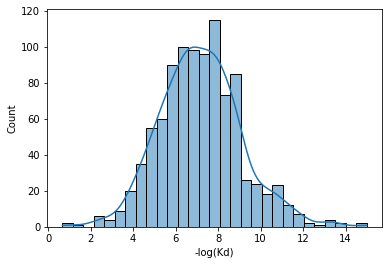

In [30]:
sns.histplot(cleaned_summary, x="-log(Kd)", kde=True)

In [31]:
cleaned_summary["-log(Kd)"].describe()

count    970.000000
mean       7.180375
std        1.933091
min        0.673664
25%        5.861918
50%        7.125271
75%        8.348041
max       15.000000
Name: -log(Kd), dtype: float64

<AxesSubplot:xlabel='-log(Kd)', ylabel='Count'>

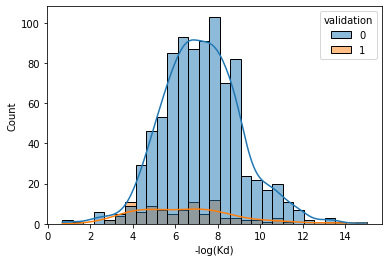

In [32]:
sns.histplot(cleaned_summary, x="-log(Kd)", hue="validation", kde=True)